# Introduction to `ELAN_Data`
***
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
***
## Introduction
This is the first of several notebooks which will get the reader familiarized with the Python package `ELAN_Data` and its various capabilities. For these tutorials, we will utilize the Corpus of Regional African American Language ([CORAAL](http://lingtools.uoregon.edu/coraal/)); specifically, we will use the `ATL_elanfiles_2020.05.tar.gz`. Please download and unzip this dataset into the dataset folder.

## Table of Contents
1. [The Basics](#the-basics)
2. [Loading, Creating & Saving Files](#loading-creating--saving-files)
3. `ELAN_Data`
4. Advanced `ELAN_Data`
5. `elan_utils`
***
## Necessary Imports

In [1]:
from elan_data import ELAN_Data
from pathlib import Path

import nltk
import re

import pandas as pd

***
## The Basics
The `elan_data` package is made of two primary Python files structured as follows:

```
src
└── elan_data
    ├── elan_utils.py
    ├── __init__.py
    └── py.typed
```

### Files
| Name | Description |
| :--- | ----------- |
| `elan_utils.py` | Contains helper methods that work with `ELAN_Data` and are planned to be adaptable to be more general purpose tools as well. |
| `__init__.py` | Contains the main `ELAN_Data` code. |
| `py.typed` | This literally does nothing but is needed so our testing framework won't be mad. >:( |

### Simple Code
To start using `elan_data` simply import its main module, `ELAN_Data` and either load-in or create an instance. To load in a pre-existing file:

In [2]:
# Load in ATL_se0_ag1_f_01_1.eaf from the downloaded dataset
# We recommend using Path to store and modify file paths; it's an official Python package and very robust
FILE = "./datasets/ATL_se0_ag1_f_01_1.eaf"
PATH = Path(FILE)

print(f"Path to .eaf file is {PATH}")

# Load in as an ELAN_Data instance
eaf = ELAN_Data.from_file(file=PATH)

Path to .eaf file is datasets/ATL_se0_ag1_f_01_1.eaf


When you run `print(eaf)`, you'll get the following information:
- The local path to the associated *ELAN* file.
- The absolute path with any backtracking (i.e. `../`); the *unresolved* file path.
- The name of all the tiers.
- The name and location of any associated audio file (if there is one).
- If the associated `pd.DataFrame` has been updated (defaults to `False`).
- If this current instance has been modified since its creation (defaults to `False`).

In [3]:
print(eaf)

name: ATL_se0_ag1_f_01_1.eaf
located at: /home/computer_cat/Documents/Programs/Python/elan_data/tutorials/datasets/ATL_se0_ag1_f_01_1.eaf
tiers: ATL_se0_ag1_f_01, ATL_int_01
associated audio file: None
associated audio location: None
dataframe init: False
modified: False



To initial the instance's `pd.DataFrame`, either specify it by setting `init_df=True` in any of its [**constructor**](https://www.geeksforgeeks.org/constructors-in-python/) methods or by running `eaf.init_dataframe()`.

In [4]:
eaf.init_dataframe()
print(eaf.tier_data)

               TIER_ID    START     STOP  \
0     ATL_se0_ag1_f_01        0      444   
1     ATL_se0_ag1_f_01      444     2407   
2     ATL_se0_ag1_f_01     2407     2683   
3     ATL_se0_ag1_f_01     2683     4954   
4     ATL_se0_ag1_f_01     4954     5149   
...                ...      ...      ...   
1773        ATL_int_01  1856180  1856347   
1774        ATL_int_01  1856347  1857625   
1775        ATL_int_01  1857625  1859418   
1776        ATL_int_01  1859418  1862488   
1777        ATL_int_01  1862488  1863000   

                                                   TEXT SEGMENT_ID  DURATION  
0                                                               a1       444  
1      They talking about, don't send him to his daddy.         a2      1963  
2                                                               a3       276  
3           You just need to go file for child support.         a4      2271  
4                                                               a5       195

In [5]:
eaf.tier_data.columns

Index(['TIER_ID', 'START', 'STOP', 'TEXT', 'SEGMENT_ID', 'DURATION'], dtype='object')

The dataframe is structured such that each row is a single segment and has the following data assoiated with its entry:
- `TIER_ID`: The name of the tier the segment is on.
- `START`: The start (in milliseconds) of the segment from the audio's beginning.
- `STOP`: The end (in milliseconds) of the segment from the audio's beginning.
- `TEXT`: The text inside the segment (an empty string if there was none).
- `SEGMENT_ID`: The ID's segment in the *ELAN* file.
- `DURATION`: How long the segment lasts (in milliseconds).

This dataframe is completely modifiable. Although you must be careful as some methods rely on these columns being guaranteed to exist in an `ELAN_Data` instance's dataframe once initialized. From this dataframe, we can gather useful statistics about the file.

<Axes: >

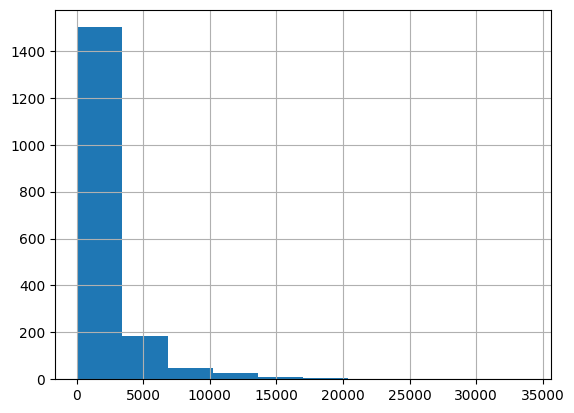

In [6]:
# Plot a histogram of segment duration times
eaf.tier_data.DURATION.hist()

In [7]:
# Get the number of segments per tier
eaf.tier_data.TIER_ID.value_counts()

TIER_ID
ATL_int_01          921
ATL_se0_ag1_f_01    857
Name: count, dtype: int64

In [8]:
# Lastly, let's combine this package with nltk to get the top 20 most used words
# Copy to not affect the eaf's underlying tier dataframe
df = eaf.tier_data.copy()

# Also filters out the brackets and empty TEXT entries get an empty list
df['TOKENS'] = df.TEXT.map(lambda x: [c for c in nltk.word_tokenize(x) if c not in "[]"])

print(df.sample(1))

        TIER_ID  START   STOP TEXT SEGMENT_ID  DURATION TOKENS
917  ATL_int_01  92473  92944            a918       471     []


<Axes: xlabel='TOKENS'>

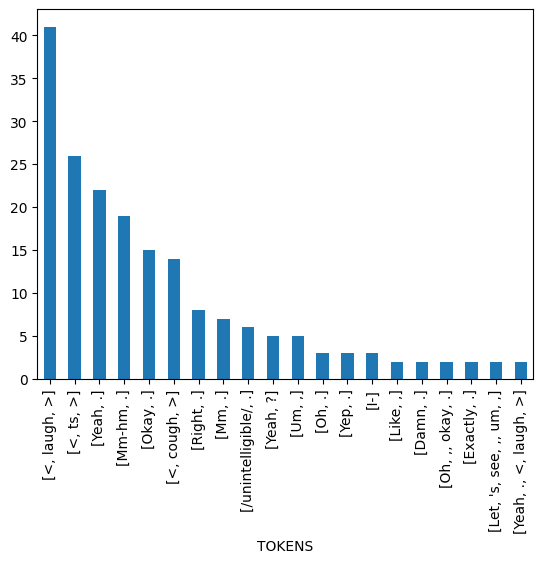

In [9]:
df[df.TOKENS.astype(str) != '[]'].TOKENS.value_counts().head(20).plot(kind="bar")

***
## Loading, Creating & Saving Files

There are a plethora of ways to both load in existing *ELAN* files (those ending with the `.eaf` extension and follow its XML rules) and create new ones using `elan_data`.

### Loading Existing Files

In [10]:
# From standard ELAN files
FILE = "./datasets/ATL_se0_ag1_f_02_1.eaf"

# Both string and path options
eaf_1 = ELAN_Data.from_file(file=FILE)
eaf_2 = ELAN_Data.from_file(file=Path(FILE))

eaf_1 == eaf_2

True

Note however that it only checks the following attributes upon comparison through the dunder `__eq__()` method:

```python
@typing.no_type_check
def __eq__(self, other: object) -> bool:

    if type(self).__name__ != type(other).__name__:
        return NotImplemented

    self.df_status = True
    other.df_status = True

    return self.file == other.file and self.audio == other.audio \
        and self._tier_names == other.tier_names and self.tier_data.equals(other.tier_data) \
        and self._modified == other.modified  # Trees is a redundant check and not guaranteed
```

This is because trees *seem* to not be evaluated in the same way as the other attributes and differing tree structures can produce the same *ELAN* file. If two structures loaded from the same file were changed differently, the other attributes *should* catch it.

### Loading through Other Formats

We can also load data from different sources; this can then be used to create new *ELAN* files afterwards. Note, however, that for a dataframe, it needs to have all the columns specified in the `ELAN_Data.tiers_data` instance.

In [11]:
# Let's make a new eaf instance through a pandas DataFrame
eaf_3 = ELAN_Data.from_dataframe(df=eaf_2.init_dataframe(), file="new.eaf")

# This eaf will not have a lot of the properties the other two had
# It uses ONLY the DataFrame to instantiate itself and relies on 
# the user to fill in the rest if needed
eaf_3 == eaf_1

False

In [12]:
# Notice how the DataFrame is guaranteed to be initialized along with the ELAN_Data object
print(eaf_3)

name: new.eaf
located at: /home/computer_cat/Documents/Programs/Python/elan_data/tutorials/new.eaf
tiers: default, ATL_se0_ag1_f_02, ATL_int_01
associated audio file: None
associated audio location: None
dataframe init: True
modified: True

